# Regression Algorithm: Golden Apple Price Prediction

## **Introduction**

The prices of Fresh Produce depend on a large number of factors which contribute to changes in the supply and demand. One of the factors that affect pricing is the amount of apples yielded in a season.  

The main aim of this project is to develop a model that predicts prices of Golden Apples per kilogram in order for the Fresh Produce industry to meet its objectives. The industry aims to ensure there is adequate stock to cater for the demand of golden apples and simultaneously mitigate the amount of stock in hand to avoid any losses or waste. To achieve this, we will identify and collect data that is relevant to the past production and pricing of apples and build a regression algorithm that is able to forecast future golden apple prices.  

## **Feature Description**

This dataset consists of over 60 000 sales made by Durban Fresh Produce Market. Below is a description of Variable names used in the dataset:

- avg_price_per_kg - average price of the produce per kg (the response)
- Province - Which province the produce was grown
- Container - The code for the type of container
- Size_Grade - The class of the produce according to their quality
- Weight_Kg - The total weight in kilograms
- Commodities - The type of produce, e.g. Golden Delicious Apples
- Date - The date of the sale
- Sales_Total - The total sales price
- Total_Qty_Sold - The number of produce sold
- Total_Kg_Sold - The total weight of the produce sold in kilograms
- Stock_On_Hand - The amount of produce the store has

## **Import Dependencies**

In [139]:
#Visualisations

import matplotlib.pyplot as plt          
import seaborn as sns
sns.set(style='whitegrid')

#Data Wrangling
import pandas as pd
import numpy as np
import math
from scipy import stats

#Modelling
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

import pickle


## **Load Data**

In [304]:
train = pd.read_csv('data/df - train_set.csv')
test = pd.read_csv('data/df - test_set.csv')
train = train[train.Commodities == 'APPLE GOLDEN DELICIOUS']
pd.options.display.max_columns=100



## **Data Cleaning**


### **Data Overview**
Before studying the dataframe we need to remove the Commodities Column as it contains one item "APPLE GOLDEN DELICIOUS"


In [141]:
train.drop("Commodities",inplace=True,axis=1)
test.drop("Commodities",inplace=True,axis=1)


Obtained the first 5 rows to get an idea of the type of data we are dealing with.

In [10]:
train.head()


,Province,Container,Size_Grade,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50


We studied the structure of our data. We retrieved the dimension, the various column names, their respective counts and data types. The data consist of 1952 rows and 12 columns. The columns consist of 8 numerical features, 3 categorical features and 1 date feature still in string format. The number of rows is the same as the number of values in each column so we can assume that the data does not contain any missing values.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          1952 non-null   object 
 1   Container         1952 non-null   object 
 2   Size_Grade        1952 non-null   object 
 3   Weight_Kg         1952 non-null   float64
 4   Date              1952 non-null   object 
 5   Low_Price         1952 non-null   float64
 6   High_Price        1952 non-null   float64
 7   Sales_Total       1952 non-null   float64
 8   Total_Qty_Sold    1952 non-null   int64  
 9   Total_Kg_Sold     1952 non-null   float64
 10  Stock_On_Hand     1952 non-null   int64  
 11  avg_price_per_kg  1952 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 198.2+ KB


We counted the number of unique values in each column.The data consists of 7 different provinces, 11 container types and 10 different size_grade. Furthermore we discovered that the data was collected over 147 different days

In [11]:
train.nunique()


Province               7
Container             11
Size_Grade            10
Weight_Kg              9
Date                 147
Low_Price             94
High_Price            88
Sales_Total         1324
Total_Qty_Sold       505
Total_Kg_Sold        850
Stock_On_Hand        735
avg_price_per_kg     601
dtype: int64

## **Exploratory Data Analysis**

### **Numerical Variables**

We obtained the summary statistics of all the numerical columns. From the table below, it is evident that all our independent numerical features are extremely skewed to the right. Their means are significantly higher than their mean. This indicates that more of the observations are to the left of the mean and that there are a couple of values to the extreme right. The response (avg_price_per_kg)

In [12]:
train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


We measured the degree of skewness for each of our numerical variables. Skewness measures the degree of asymmetry in our data. Symmetric distributions have a near zero skewness. Distributions with a positive coefficient of skewness are said to be skewed to the right. The same is true about distributions with a negative value. A common measure of skewness is the  adjusted Fisher-Pearson coefficient of skewness and it is given by this formula:
$$G_1=\frac{\sqrt{N\times(N-1)}}{N-2}\times\frac{\sum_{i=1}^{N} (Y_i-\bar{Y})^{2}}{s^2}$$
As we suspected explanatory variables are exhibiting positive skewness and the avg_price_per kg is fairly symmetrical.


In [13]:
train.skew()

Weight_Kg           3.328254
Low_Price           4.222672
High_Price          3.828819
Sales_Total         4.250317
Total_Qty_Sold      4.445169
Total_Kg_Sold       5.529586
Stock_On_Hand       3.391815
avg_price_per_kg    0.082452
dtype: float64

In [9]:
train.kurtosis()

Weight_Kg            9.109698
Low_Price           17.073369
High_Price          13.630768
Sales_Total         24.200524
Total_Qty_Sold      32.338123
Total_Kg_Sold       45.153801
Stock_On_Hand       14.671224
avg_price_per_kg     1.042921
dtype: float64

Furthermore we plotted the histograms of all the numerical variables, and they confirmed the above findings.

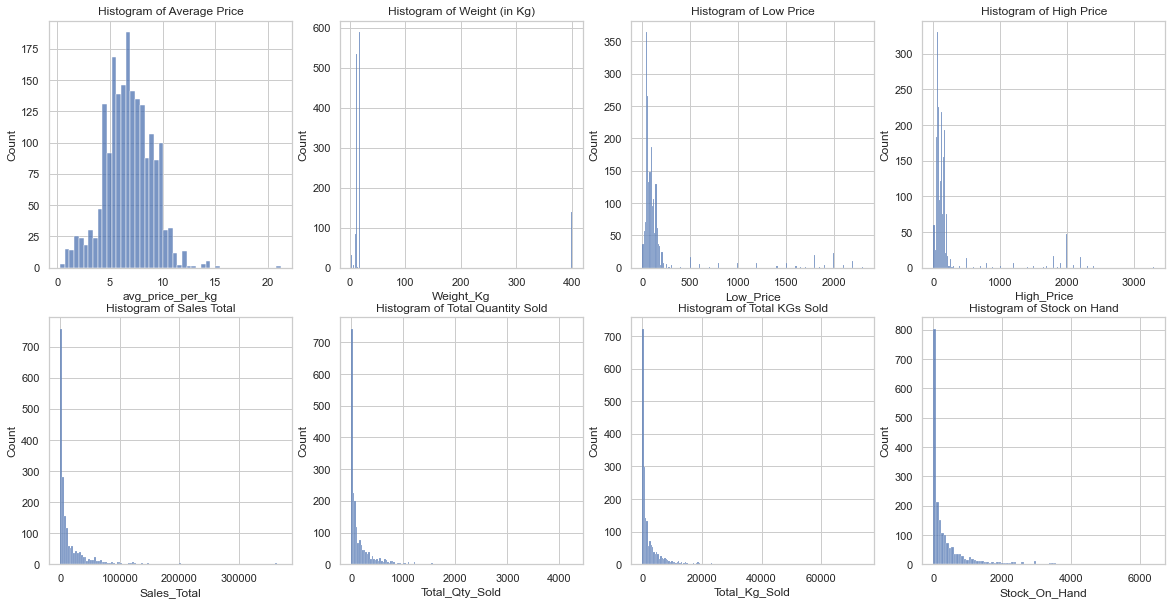

In [14]:

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

a = sns.histplot(train.avg_price_per_kg,ax=axs[0,0])
a.set_title("Histogram of Average Price")

b = sns.histplot(train.Weight_Kg,ax=axs[0,1])
b.set_title("Histogram of Weight (in Kg)")

c = sns.histplot(train.Low_Price,ax=axs[0,2])
c.set_title("Histogram of Low Price")

d = sns.histplot(train.High_Price,ax=axs[0,3],)
d.set_title("Histogram of High Price")

e = sns.histplot(train.Sales_Total,ax=axs[1,0])
e.set_title("Histogram of Sales Total")

f = sns.histplot(train.Total_Qty_Sold,ax=axs[1,1])
f.set_title("Histogram of Total Quantity Sold")

g = sns.histplot(train.Total_Kg_Sold,ax=axs[1,2])
g.set_title("Histogram of Total KGs Sold")

h = sns.histplot(train.Stock_On_Hand,ax=axs[1,3])
h.set_title("Histogram of Stock on Hand")

plt.show()


Now let us evaluate whether time has an effect on the average price of golden delicious apples. We plotted the average price per kg and its 7-day moving average against the date. Firstly we found that the average price varies from day-to-day. Secondly, we discovered that Golden Delicious Apples are generally more expensive the in the summer (December, January). Furthermore their prices generally decrease from the month of February up to the beginning of May when they start picking back up again. They finally reach a peak in the middle of June and then remain stable until October.

In [285]:
#Convert to date time training set
    
train['Date'] = pd.to_datetime(train['Date']) 
train['Month']=train['Date'].dt.month_name()
train['Day_of_Month']=train['Date'].dt.day
train['Day_of_Week']=train['Date'].dt.day_name()

#converting for test
test['Date'] = pd.to_datetime(test['Date']) 
test['Month']=test['Date'].dt.month_name()
test['Day_of_Month']=test['Date'].dt.day
test['Day_of_Week']=test['Date'].dt.day_name()


In [263]:
train.head()

,Province,Container,Size_Grade,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg,Month,Day_of_Month,Day_of_Week
1,CAPE,M4183,1L,18.3,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51,September,9,Wednesday
7,CAPE,JG110,2M,11.0,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55,April,14,Tuesday
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11,April,16,Thursday
40,CAPE,M4183,1S,18.3,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51,May,4,Monday
69,EASTERN CAPE,IA400,1S,400.0,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50,September,28,Monday


In [264]:
test.head()

,Index,Province,Container,Size_Grade,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Month,Day_of_Month,Day_of_Week
0,1,W.CAPE-BERGRIVER ETC,EC120,1M,12.0,2020-07-09,128.0,136.0,5008.0,38,456.0,0,July,9,Thursday
1,2,W.CAPE-BERGRIVER ETC,M4183,1X,18.3,2020-01-20,220.0,220.0,1760.0,8,146.4,2,January,20,Monday
2,3,W.CAPE-BERGRIVER ETC,EC120,1S,12.0,2020-08-19,120.0,120.0,720.0,6,72.0,45,August,19,Wednesday
3,4,W.CAPE-BERGRIVER ETC,M4183,1M,18.3,2020-05-06,160.0,160.0,160.0,1,18.3,8,May,6,Wednesday
4,5,W.CAPE-BERGRIVER ETC,M4183,1L,18.3,2020-05-04,140.0,160.0,14140.0,100,1830.0,19,May,4,Monday


In [18]:
#getting the average_per_kg_per_dat
df_1 = train.groupby(['Date'], as_index=False)['avg_price_per_kg'].mean()
df_2=train.groupby(['Month'], as_index=False)['avg_price_per_kg'].mean()
df_3=train.groupby(['Day_of_Week'], as_index=False)['avg_price_per_kg'].mean()
df_4=train.groupby(['Day_of_Month'], as_index=False)['avg_price_per_kg'].mean()

#Obtaining the rolling average
df_1["rolling_eve"]=df_1.avg_price_per_kg.rolling(7).mean().shift(-3)

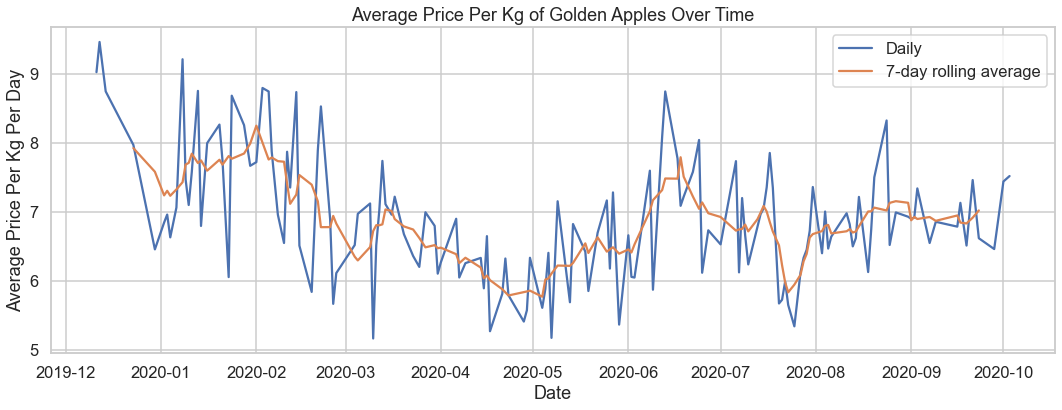

In [19]:
sns.set_context("talk")
plt.figure(figsize=(18,6))
sns.lineplot(x="Date",y='avg_price_per_kg', label="Daily",data=df_1)
sns.lineplot(x="Date",y='rolling_eve', label="7-day rolling average",data=df_1)
plt.title('Average Price Per Kg of Golden Apples Over Time')
plt.ylabel('Average Price Per Kg Per Day')
plt.xlabel('Date')
plt.show()


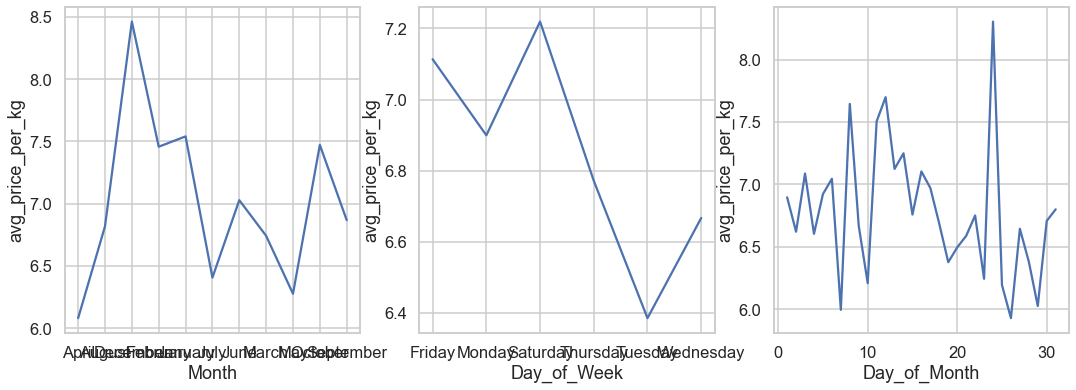

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.lineplot(x='Month',y='avg_price_per_kg',data=df_2,ax=axs[0])
sns.lineplot(x='Day_of_Week',y='avg_price_per_kg',data=df_3,ax=axs[1])
sns.lineplot(x='Day_of_Month',y='avg_price_per_kg',data=df_4,ax=axs[2])
plt.show()


We checked how each of the numerical features is related to the avg_price_per_kg and discovered the low price and high price have a similar effect on average price (a cone-like increasing effect). Sales_Total, Total_Qty_Sold, Total_Kg, Stock_On_Hand also displayed a near identical effect on average price.

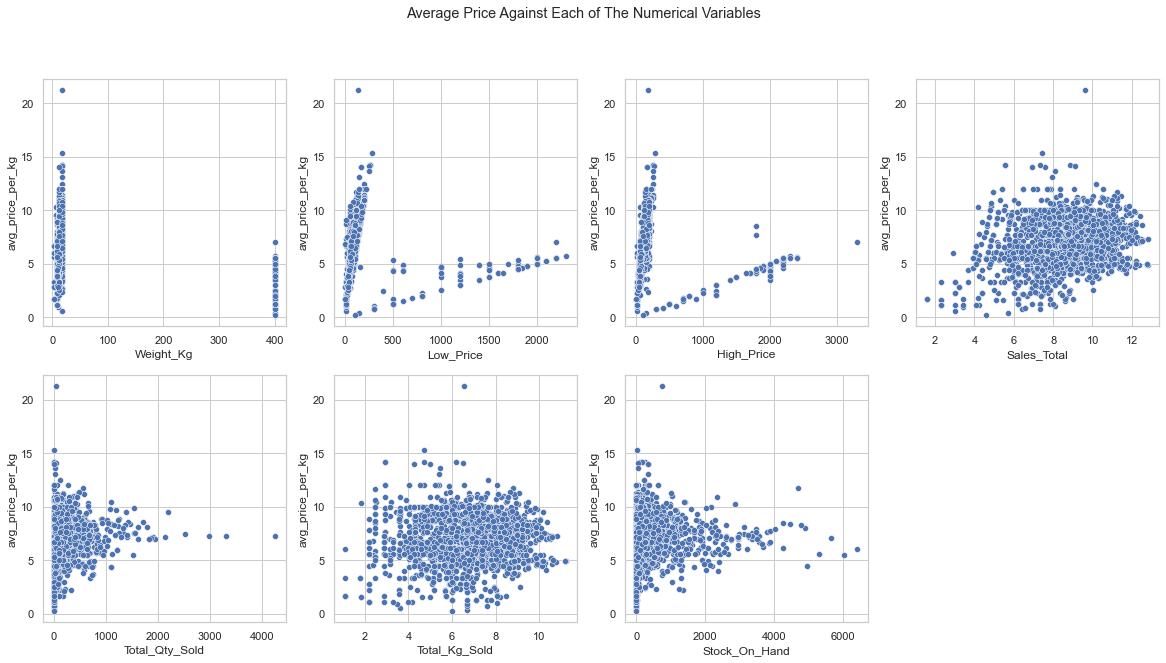

In [291]:

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

sns.scatterplot(x = 'Weight_Kg',y = 'avg_price_per_kg',ax=axs[0,0],data = train)


sns.scatterplot(x = 'Low_Price',y = 'avg_price_per_kg',ax=axs[0,1],data = train)


sns.scatterplot(x = 'High_Price',y = 'avg_price_per_kg', ax=axs[0,2],data = train)


sns.scatterplot(x = 'Sales_Total',y = 'avg_price_per_kg',ax=axs[0,3],data = train)


sns.scatterplot(x = 'Total_Qty_Sold',y = 'avg_price_per_kg',ax=axs[1,0],data = train)


sns.scatterplot(x = 'Total_Kg_Sold',y = 'avg_price_per_kg',ax=axs[1,1],data = train)


sns.scatterplot(x = 'Stock_On_Hand',y = 'avg_price_per_kg',ax=axs[1,2], data = train)

#main title
fig.suptitle('Average Price Against Each of The Numerical Variables')

#dropping the last figure
fig.delaxes(axs[1,3])

plt.show()

We constructed a correlation heatmap for the numerical variables to check if any linear relationships exist between our response variables and independent features, and between the independent features themselves. We found that the independent variables have a low correlation with the response variable. Furthermore we discovered Weight_kg,Low_Price,and High_Price are highly positively correlated. The Sales_Total and Total_kg_Sold are also highly correlated. 

In [292]:
num_fil=['avg_price_per_kg','Weight_Kg','Low_Price','High_Price','Sales_Total', 'Total_Qty_Sold','Total_Kg_Sold','Stock_On_Hand']
num_df=train[num_fil]

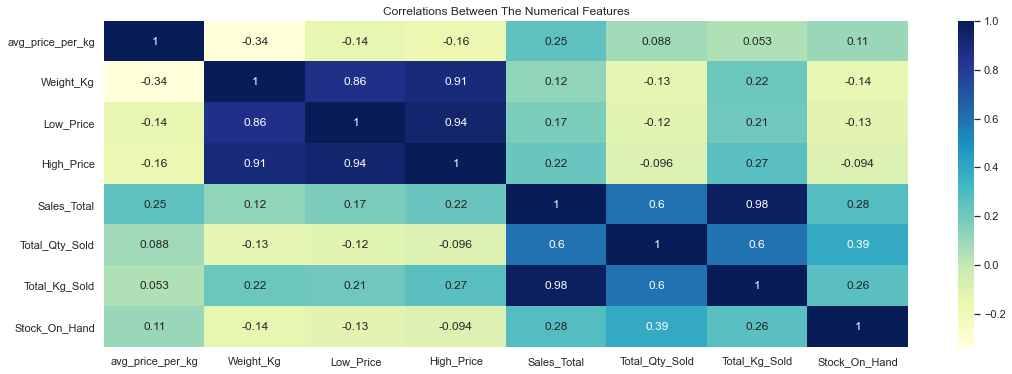

In [293]:
plt.figure(figsize = (18,6))
heat_map = sns.heatmap(num_df.corr(),annot=True, cmap="YlGnBu")
heat_map.set_title('Correlations Between The Numerical Features')
plt.show()


## **Categorical Variables**

We plotted the count of each category
Most of the apples are produced in the CAPE region. Orange Free state produced the least number of apples. 

1S size_grade is the most produced


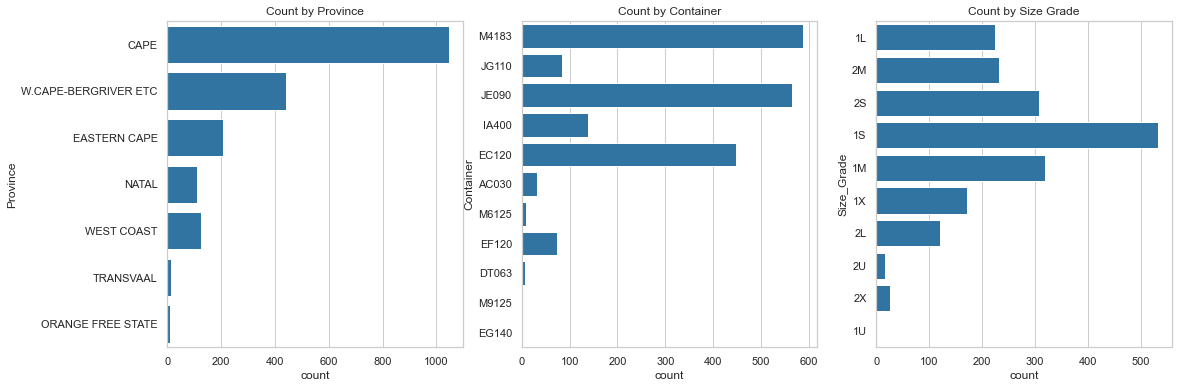

In [107]:
fig, axs = plt.subplots(1,3, figsize=(18, 6))

cp1 = sns.countplot(y = 'Province',data = train, ax=axs[0],color='#1f77b4')
cp2 = sns.countplot(y = 'Container', ax=axs[1],data = train,color='#1f77b4')
cp3 = sns.countplot(y = 'Size_Grade', ax=axs[2],data = train,color='#1f77b4')
cp1.set_title("Count by Province")
cp2.set_title("Count by Container")
cp3.set_title("Count by Size Grade")

plt.show()


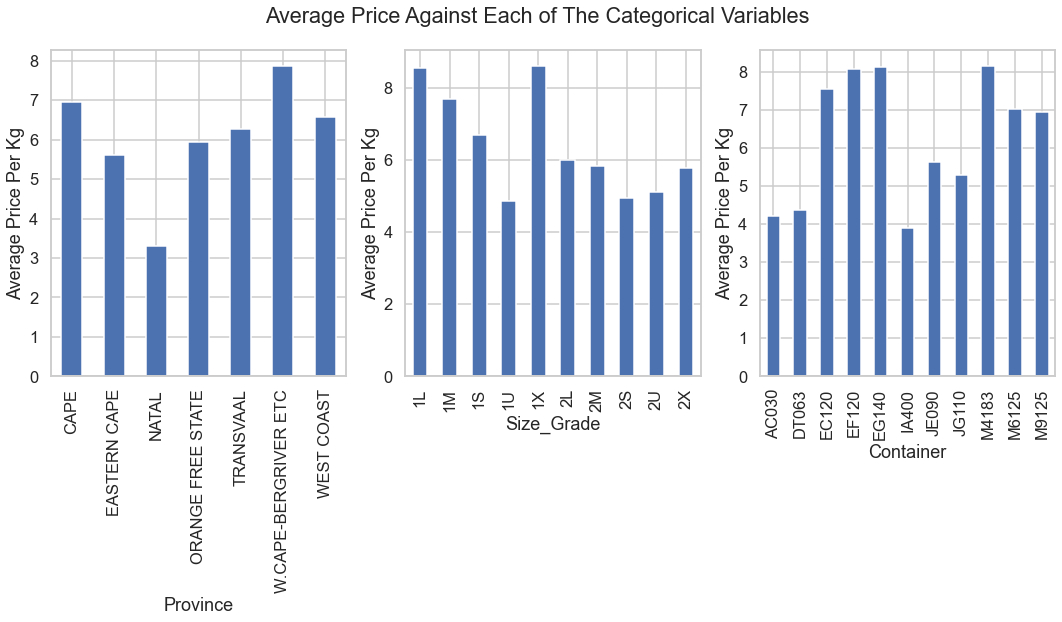

In [25]:
fig, axs = plt.subplots(1,3, figsize=(18, 6))

gb1 = train.groupby(train['Province'])['avg_price_per_kg'].mean().plot(kind='bar', ax=axs[0])
gb2 = train.groupby(train['Size_Grade'])['avg_price_per_kg'].mean().plot(kind='bar',ax=axs[1])
gb3 = train.groupby(train['Container'])['avg_price_per_kg'].mean().plot(kind='bar',ax=axs[2])

gb1.set_ylabel("Average Price Per Kg")
gb2.set_ylabel("Average Price Per Kg")
gb3.set_ylabel("Average Price Per Kg")

fig.suptitle('Average Price Against Each of The Categorical Variables')
plt.show()


## **Feature Engineering**


Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms.

### **Encoding Categorical Variables**


Machine learning models requires all input and output variables to be numeric. This means that if your data contains categorical data, you must encode it to numbers before you can fit and evaluate a model. **get_dummies()** is used for data manipulation. It converts categorical data into dummy or indicator variables.

<img src="Images/Encoding_example.jpeg"
     style="float: center; padding-bottom=0.5em"
     width=600px/>

In [294]:
df_train = pd.get_dummies(train,drop_first=True)
df_train.columns = [col.replace(" ","_") for col in df_train.columns]

df_test = pd.get_dummies(test,drop_first=True)
df_test.columns = [col.replace(" ","_") for col in df_test.columns]

In [295]:
df_train.head(5)

,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg,Day_of_Month,Province_EASTERN_CAPE,Province_NATAL,Province_ORANGE_FREE_STATE,Province_TRANSVAAL,Province_W.CAPE-BERGRIVER_ETC,Province_WEST_COAST,Container_DT063,Container_EC120,Container_EF120,Container_EG140,Container_IA400,Container_JE090,Container_JG110,Container_M4183,Container_M6125,Container_M9125,Size_Grade_1M,Size_Grade_1S,Size_Grade_1U,Size_Grade_1X,Size_Grade_2L,Size_Grade_2M,Size_Grade_2S,Size_Grade_2U,Size_Grade_2X,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_October,Month_September,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday
1,18.3,2020-09-09,150.0,170.0,10.853406,332,8.712036,822,8.51,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
7,11.0,2020-04-14,50.0,50.0,9.680344,320,8.166216,0,4.55,14,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
24,9.0,2020-04-16,55.0,55.0,6.897705,18,5.087596,1506,6.11,16,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
40,18.3,2020-05-04,80.0,120.0,10.374116,388,8.867906,443,4.51,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
69,400.0,2020-09-28,1800.0,1800.0,7.495542,1,5.991465,2,4.50,28,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


In [205]:
df_test.head()

,Index,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Day_of_Month,Province_EASTERN_CAPE,Province_NATAL,Province_ORANGE_FREE_STATE,Province_TRANSVAAL,Province_W.CAPE-BERGRIVER_ETC,Province_WEST_COAST,Container_DT063,Container_EC120,Container_EF120,Container_EG140,Container_IA400,Container_JE090,Container_JG110,Container_M4183,Container_M6125,Container_M9125,Size_Grade_1M,Size_Grade_1S,Size_Grade_1U,Size_Grade_1X,Size_Grade_2L,Size_Grade_2M,Size_Grade_2S,Size_Grade_2U,Size_Grade_2X,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_October,Month_September,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday
0,1,12.0,2020-07-09,128.0,136.0,5008.0,38,456.0,0,9,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,2,18.3,2020-01-20,220.0,220.0,1760.0,8,146.4,2,20,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,3,12.0,2020-08-19,120.0,120.0,720.0,6,72.0,45,19,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4,18.3,2020-05-06,160.0,160.0,160.0,1,18.3,8,6,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,5,18.3,2020-05-04,140.0,160.0,14140.0,100,1830.0,19,4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


### Binning The Categorical Variables

#### Size Grade
From the figure above we saw that some size_grade seem to have the same effect on the price so we decided to bin them

In [228]:
#1L 1X group will be our reference 
df_train['Size_Grade_2L2M2X'] = df_train[['Size_Grade_2L','Size_Grade_2M','Size_Grade_2X']].max(axis=1)

df_train['Size_Grade_1U2S2U'] = df_train[['Size_Grade_1U','Size_Grade_2S','Size_Grade_2U']].max(axis=1)
df_train.drop(['Size_Grade_2L','Size_Grade_2M','Size_Grade_2X','Size_Grade_1U'\
               ,'Size_Grade_2S','Size_Grade_2U','Size_Grade_1X'],axis=1, inplace = True)


df_test['Size_Grade_2L2M2X'] = df_test[['Size_Grade_2L','Size_Grade_2M','Size_Grade_2X']].max(axis=1)

df_test['Size_Grade_1U2S2U'] = df_test[['Size_Grade_1U','Size_Grade_2S','Size_Grade_2U']].max(axis=1)
df_test.drop(['Size_Grade_2L','Size_Grade_2M','Size_Grade_2X','Size_Grade_1U'\
               ,'Size_Grade_2S','Size_Grade_2U','Size_Grade_1X'],axis=1, inplace = True)

In [30]:
df_train.head()

,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg,Day_of_Month,Province_EASTERN_CAPE,Province_NATAL,Province_ORANGE_FREE_STATE,Province_TRANSVAAL,Province_W.CAPE-BERGRIVER_ETC,Province_WEST_COAST,Container_DT063,Container_EC120,Container_EF120,Container_EG140,Container_IA400,Container_JE090,Container_JG110,Container_M4183,Container_M6125,Container_M9125,Size_Grade_1M,Size_Grade_1S,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_October,Month_September,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,Size_Grade_2L2M2X,Size_Grade_1U2S2U
1,18.3,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
7,11.0,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55,14,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
24,9.0,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11,16,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
40,18.3,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
69,400.0,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50,28,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [31]:
df_test.head()

,Index,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Day_of_Month,Province_EASTERN_CAPE,Province_NATAL,Province_ORANGE_FREE_STATE,Province_TRANSVAAL,Province_W.CAPE-BERGRIVER_ETC,Province_WEST_COAST,Container_DT063,Container_EC120,Container_EF120,Container_EG140,Container_IA400,Container_JE090,Container_JG110,Container_M4183,Container_M6125,Container_M9125,Size_Grade_1M,Size_Grade_1S,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_October,Month_September,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,Size_Grade_2L2M2X,Size_Grade_1U2S2U
0,1,12.0,2020-07-09,128.0,136.0,5008.0,38,456.0,0,9,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,2,18.3,2020-01-20,220.0,220.0,1760.0,8,146.4,2,20,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,12.0,2020-08-19,120.0,120.0,720.0,6,72.0,45,19,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,18.3,2020-05-06,160.0,160.0,160.0,1,18.3,8,6,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,5,18.3,2020-05-04,140.0,160.0,14140.0,100,1830.0,19,4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


#### Container

In [229]:
#AC030 DT063 JA400 are the reference group

df_train['Container_JEJG'] = df_train[['Container_JE090','Container_JG110']].max(axis = 1)
df_train['Container_M6M9'] = df_train[['Container_M6125','Container_M9125']].max(axis = 1)
df_train['Container_ECEFEG'] = df_train[['Container_EC120','Container_EF120','Container_EG140']].max(axis = 1)
df_train.drop(['Container_JE090','Container_JG110','Container_M6125','Container_M9125',\
                 'Container_EC120','Container_EF120','Container_EG140','Container_DT063',\
               'Container_IA400'],axis = 1,inplace = True)

df_test['Container_JEJG'] = df_test[['Container_JE090','Container_JG110']].max(axis = 1)
df_test['Container_M6M9'] = df_test[['Container_M6125','Container_M9125']].max(axis = 1)
df_test['Container_ECEFEG'] = df_test[['Container_EC120','Container_EF120','Container_EG140']].max(axis = 1)
df_test.drop(['Container_JE090','Container_JG110','Container_M6125','Container_M9125',\
                 'Container_EC120','Container_EF120','Container_EG140','Container_DT063',\
               'Container_IA400'],axis = 1,inplace = True)



#### Province 

In [230]:
df_train['Province_TRWC'] = df_train[['Province_TRANSVAAL','Province_WEST_COAST']].max(axis = 1)
df_train['Province_FSEC'] = df_train[['Province_ORANGE_FREE_STATE','Province_EASTERN_CAPE']].max(axis = 1)
df_train.drop(['Province_TRANSVAAL','Province_WEST_COAST','Province_ORANGE_FREE_STATE','Province_EASTERN_CAPE'],\
             axis = 1, inplace = True)

df_test['Province_TRWC'] = df_test[['Province_TRANSVAAL','Province_WEST_COAST']].max(axis = 1)
df_test['Province_FSEC'] = df_test[['Province_ORANGE_FREE_STATE','Province_EASTERN_CAPE']].max(axis = 1)
df_test.drop(['Province_TRANSVAAL','Province_WEST_COAST','Province_ORANGE_FREE_STATE','Province_EASTERN_CAPE']\
             ,axis = 1, inplace = True)



Next we break-down our time component into month,day of month, day of week.

In [296]:
#getting our response to be at the end
cols = list(df_train.columns.values)
cols.pop(cols.index('avg_price_per_kg'))
cols.pop(cols.index('Date')) #dropping the  data column for now
df_train = df_train[cols+['avg_price_per_kg']]
df_test.drop(['Date'],axis = 1, inplace = True)




In [255]:
df_train.head()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Month,Day_of_Month,Day_of_Week,Province_EASTERN_CAPE,Province_NATAL,Province_ORANGE_FREE_STATE,Province_TRANSVAAL,Province_W.CAPE-BERGRIVER_ETC,Province_WEST_COAST,Container_DT063,Container_EC120,Container_EF120,Container_EG140,Container_IA400,Container_JE090,Container_JG110,Container_M4183,Container_M6125,Container_M9125,Size_Grade_1M,Size_Grade_1S,Size_Grade_1U,Size_Grade_1X,Size_Grade_2L,Size_Grade_2M,Size_Grade_2S,Size_Grade_2U,Size_Grade_2X,avg_price_per_kg
1,18.3,150.0,170.0,51710.0,332,6075.6,822,9,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8.51
7,11.0,50.0,50.0,16000.0,320,3520.0,0,4,14,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4.55
24,9.0,55.0,55.0,990.0,18,162.0,1506,4,16,3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,6.11
40,18.3,80.0,120.0,32020.0,388,7100.4,443,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,4.51
69,400.0,1800.0,1800.0,1800.0,1,400.0,2,9,28,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4.50


In [218]:
df_test.head()

,Index,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Day_of_Month,Province_NATAL,Province_W.CAPE-BERGRIVER_ETC,Container_M4183,Size_Grade_1M,Size_Grade_1S,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_October,Month_September,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,Size_Grade_2L2M2X,Size_Grade_1U2S2U,Container_JEJG,Container_M6M9,Container_ECEFEG,Province_TRWC,Province_FSEC
0,1,12.0,128.0,136.0,5008.0,38,456.0,0,9,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,2,18.3,220.0,220.0,1760.0,8,146.4,2,20,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,12.0,120.0,120.0,720.0,6,72.0,45,19,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,4,18.3,160.0,160.0,160.0,1,18.3,8,6,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,5,18.3,140.0,160.0,14140.0,100,1830.0,19,4,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Variable Selection


In [90]:
corrs = df_train.corr()['avg_price_per_kg'].sort_values(ascending=False)


In [91]:
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'avg_price_per_kg']
for col in column_titles:
    p_val = round(pearsonr(df_train[col], df_train['avg_price_per_kg'])[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs[col],
                    'P_Value':p_val}

df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted

,Correlation_Coefficient,P_Value
Container_M4183,0.399850,0.000000
Size_Grade_2S,-0.358012,0.000000
Weight_Kg,-0.345755,0.000000
Container_JE090,-0.322686,0.000000
Province_EASTERN_CAPE,-0.178839,0.000000
High_Price,-0.170908,0.000000
Size_Grade_2M,-0.152369,0.000000
Low_Price,-0.148941,0.000000
Container_JG110,-0.141360,0.000000
Container_IA400,-0.363334,0.000000


## Train-Validation Split

In [297]:
#discarded=['Size_Grade_1S','Province_WEST_COAST','Container_M6M9','Province_TRANSVAAL','Total_Kg_Sold','Month','Province_ORANGE_FREE_STATE']
#df_train.drop(discarded,axis=1,inplace=True)
#df_test.drop(discarded,axis=1,inplace=True)

X=df_train.iloc[:,:-1].values #taking everything besides the last column

y=df_train.iloc[:,-1].values #the response


In [270]:

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2, random_state=1)

In [298]:
X_test=df_test.iloc[:,1:].values
X_test.shape

(685, 48)

## Feature Scaling
There are two widely used scaling techniques: Standardisation and Min-Mix Normalisation. Standardisation rescales the data points to ensure that our data has a mean of 0 and a standard deviation of 1. Using the following equation
$$x_{stand}=\frac{x-\mu}{\sigma}$$
Min-Max Normalisation maps all the points to the [0,1] interval using this equation
$$x_{norm}=\frac{x-\min{x}}{\max{x}-\min{x}}$$
Since our data is skewed, we opted for the standardisation since it has been shown in the past to be more robust to outliers>


In [155]:
sc_X = StandardScaler()
X_train_stand = sc_X.fit_transform(X_train)

X_val_stand = sc_X.transform(X_val)

X_test_stand =sc_X.transform(X_test)


## Model Training        

### Model 1 : Multiple Linear Regression
Multiple linear regression allows you to model the relationship between a the response variable and a set of explanatory variable(s) by fitting a line/hyperplane that minimizes the squared distance between itself and our observations. It is given by the following formula:
$$y_i=\beta_0+\beta_1x_{i1}+\beta_2x_{i2}+...+\beta_{k}x_{ik}+e_i$$
Where:
* Y  is the reponse variable which depends on the  p  predictor variables;
* β0  is the intercept, interpreted as the value of  Y  when all predictor variables are equal to zero;
* βj  is the average effect on  Y  of a one unit increase in  Xj , assuming all other predictors are held fixed.

Assumptions:

Regression residuals must be normally distributed.

A linear relationship is assumed between the dependent variable and the independent variables.

The residuals are homoscedastic and approximately rectangular-shaped.

Absence of multicollinearity is assumed in the model, meaning that the independent variables are not too highly correlated.

In [92]:

#Fitting a basic linear Model
lm=LinearRegression()
lm.fit(X_train_stand,y_train)

LinearRegression()

#### Model Performance

In [93]:
y_train_pred1 = lm.predict(X_train_stand)
y_val_pred1 = lm.predict(X_val_stand)


In [94]:
MRSStrain1 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred1))
MRSSval1 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred1))
print('The training Root Mean Squared Error is:',MRSStrain1,'.The validation Root Mean Squared Error is:',MRSSval1)

The training Root Mean Squared Error is: 1.2577423620606947 .The validation Root Mean Squared Error is: 486369223175.074


### Model 1 Prediction

In [123]:
X_test=df_test.iloc[:,1:].values

In [874]:
y_pred1 = regressor.predict(X_test)

In [876]:
submission = pd.DataFrame({'Index': test.Index, 'avg_price_per_kg': y_pred1})

In [877]:
submission.head()


,Index,avg_price_per_kg
0,1,8.823697
1,2,8.921020
2,3,8.506357
3,4,8.651164
4,5,8.335139


In [487]:
submission.to_csv(r'C:\Users\nknhl\OneDrive\Documents\GitHub\Team_7_regression\2nd_submission.csv', index = False)


### Model 2:  Ridge Regression
Ridge regression is a method for analysining multiple regression data that suffers from multicollinearity. When multicollinearity exists our estimates are unbiased but their variance is high and hence produce unrelable results. It is used as a method for reducing overfitting, producing better out-sample predictions than the standard method> We introduce a penalty term to our RSS calculations. Now our objective is to minimize this:


$$\text{Objective} = \min_{\beta}\left(\sum_{i=1}^n(y_i-(a+\sum_{j=1}^pb_jx_{ij}))^2 + \alpha\sum_{j=1}^pb_j^2\right)$$

Which can be written as:
$$\text{Objective} = \min_{\beta} \left(RSS + \alpha\sum_{j=1}^pb_j^2\right)$$




In [44]:
ridge = Ridge()
ridge.fit(X_train_stand,y_train)

Ridge()

In [46]:
y_train_pred2 = ridge.predict(X_train_stand)
y_val_pred2 = ridge.predict(X_val_stand)

In [47]:
MRSStrain2 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred2))
MRSSval2 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred2))
print('The training Root Mean Squared Error is:',MRSStrain2,'.The validation Root Mean Squared Error is:',MRSSval2)

The training Root Mean Squared Error is: 1.3584680615134102 .The validation Root Mean Squared Error is: 1.2051560703157316


In [881]:
y_pred2 = ridge.predict(X_test)

#y_pred2=list(np.concatenate(sc_y.inverse_transform(y_pred2)).flat)


In [882]:

submission2 = pd.DataFrame({'Index': test.Index, 'avg_price_per_kg': y_pred2})
submission2.head()

,Index,avg_price_per_kg
0,1,8.847641
1,2,8.917163
2,3,8.508041
3,4,8.667651
4,5,8.327164


In [621]:
submission.to_csv(r'C:\Users\nknhl\OneDrive\Documents\GitHub\Team_7_regression\ridge_submission.csv', index = False)

### Model 3: Decision Tree

In [95]:
regr_tree = DecisionTreeRegressor()

In [96]:
regr_tree.fit(X_train,y_train)

DecisionTreeRegressor()

In [97]:
y_train_pred3 = regr_tree.predict(X_train)
y_val_pred3 = regr_tree.predict(X_val)

In [98]:
MRSStrain3 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred3))
MRSSval3 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred3))
print('The training Root Mean Squared Error is:',MRSStrain3,'.The validation Root Mean Squared Error is:',MRSSval3)

The training Root Mean Squared Error is: 7.640532541410673e-16 .The validation Root Mean Squared Error is: 0.8298977853869905


In [61]:
y_pred3 = ridge.predict(X_test)

In [964]:
submission3 = pd.DataFrame({'Index': test.Index, 'avg_price_per_kg': y_pred3})
submission3.head()

,Index,avg_price_per_kg
0,1,8.847641
1,2,8.917163
2,3,8.508041
3,4,8.667651
4,5,8.327164


In [965]:
submission3.to_csv(r'C:\Users\nknhl\OneDrive\Documents\GitHub\Team_7_regression\dectree3_submission.csv', index = False)

### Model 4 : XGBoost

In [300]:
gbm_param_grid = {'learning_rate': [0.3],'max_depth':[3],'min_child_weight':[7],'n_estimators': [4000],'subsample': [0.8]}
gbm = xgb.XGBRegressor()
grid_mse = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_mse.fit(X, y)
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 4000, 'subsample': 0.8}
Lowest RMSE found:  0.49920271111051046


In [301]:
model = xgb.XGBRegressor(learning_rate= 0.3,max_depth=3,min_child_weight=7,n_estimators= 5000,subsample= 0.8)
model.fit(X_train,y_train)
y_train_pred4=model.predict(X_train)
y_val_pred4 = model.predict(X_val)

In [303]:
MRSStrain4 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred4))
MRSSval4 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred4))

print('The training Root Mean Squared Error is:',MRSStrain4,'.The validation Root Mean Squared Error is:',MRSSval4)

The training Root Mean Squared Error is: 0.0017240498290042303 .The validation Root Mean Squared Error is: 0.4244178918338892


In [244]:
y_pred=model.predict(X_test)
submission4 = pd.DataFrame({'Index': test.Index, 'avg_price_per_kg': y_pred})
submission4.head()



,Index,avg_price_per_kg
0,1,10.855004
1,2,12.578363
2,3,10.057527
3,4,8.826754
4,5,7.793043


In [58]:
#Saving trained Model
model_save_path = r"C:\Users\nknhl\OneDrive\Documents\GitHub\regression-apples-predict-api-template\assets\trained-models\apples_xgboost_regression.pkl"

with open(model_save_path,'wb') as file:
    pickle.dump(xgb,file)

In [237]:
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(h, y_pred)))

In [245]:
submission4.to_csv(r'C:\Users\nknhl\OneDrive\Documents\GitHub\Team_7_regression\xgboost_submission.csv', index = False)

### Model 5 : Random Forest


In [ ]:
rf=RandomForestRegressor(n_jobs = 1)
rf.fit(X_train,y_train)



In [135]:
y_valp1=rf.predict(X_val)


In [136]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_valp1)))

Root Mean Squared Error: 0.5527912304388772


In [7]:
submission5 = pd.DataFrame({'Index': test.Index, 'avg_price_per_kg': y_pred})
submission5.head()

,Index,avg_price_per_kg
0,1,10.982456
1,2,12.021858
2,3,10.000000
3,4,8.743169
4,5,7.726776


### Model 6: LightGB

In [137]:
lgb = LGBMRegressor()

In [139]:
lgb.fit(X_train,y_train)

LGBMRegressor()

In [140]:
y_valp2=lgb.predict(X_val)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_valp2)))

Root Mean Squared Error: 0.4982273025138547


In [141]:
y_pred6=lgb.predict(X_test)

In [142]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(h, y_pred6)))

Root Mean Squared Error: 0.5307503495364438


In [ ]:
submission6 = pd.DataFrame({'Index': test.Index, 'avg_price_per_kg': y_pred})
submission6.head()


### Model 7: Catboost

## Model Selection

In [143]:
importance = dt.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

NameError: name 'dt' is not defined